# Определение стоимости автомобилей

Для сервиса по продаже автомобилей с пробегом, необходимо создать модель для оценки рыночной стоимости автомобиля по историческим данным.

Необходимо учитывать 3 важных параметра:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [93]:
#!pip install library -U --user
#!pip install -U seaborn
#!pip install catboost
#!pip install lightgbm

In [94]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time

pd.set_option('display.max_columns', None)

In [95]:
try:
    data = pd.read_csv("autos.csv")
    
except FileNotFoundError:
    data = pd.read_csv("/datasets/autos.csv")

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [97]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
51956,2016-03-09 22:40:09,2900,NaN,2017,manual,0,NaN,125000,0,petrol,mercedes_benz,no,2016-03-09 00:00:00,0,30938,2016-03-17 07:47:20
188851,2016-03-06 13:41:25,300,small,1999,manual,55,punto,150000,1,petrol,fiat,no,2016-03-06 00:00:00,0,54290,2016-04-06 05:45:59
69740,2016-03-19 15:53:37,110,small,2000,manual,0,cuore,125000,4,petrol,daihatsu,NaN,2016-03-19 00:00:00,0,89073,2016-03-24 10:47:22
333111,2016-03-24 12:53:48,19950,small,2013,manual,184,cooper,40000,10,petrol,mini,no,2016-03-24 00:00:00,0,36037,2016-04-03 03:46:31
21614,2016-03-17 17:49:39,5000,coupe,1976,NaN,0,other,150000,5,NaN,porsche,yes,2016-03-17 00:00:00,0,6847,2016-03-17 17:49:39
123590,2016-03-25 13:39:47,6400,small,2009,manual,60,fabia,60000,10,petrol,skoda,no,2016-03-25 00:00:00,0,50999,2016-04-06 15:44:35
348304,2016-03-25 13:36:22,3650,wagon,2004,manual,179,a4,150000,1,gasoline,audi,no,2016-03-25 00:00:00,0,21109,2016-04-06 15:44:33
118774,2016-03-10 08:56:40,11999,wagon,2012,manual,136,i_reihe,100000,9,gasoline,hyundai,no,2016-03-10 00:00:00,0,33818,2016-03-20 09:18:16
316032,2016-04-02 17:36:22,14500,suv,2005,auto,313,touareg,150000,8,gasoline,volkswagen,no,2016-04-02 00:00:00,0,89522,2016-04-06 18:16:21
336604,2016-03-10 11:40:58,1999,NaN,2018,NaN,90,golf,125000,5,NaN,volkswagen,NaN,2016-03-10 00:00:00,0,30455,2016-04-04 21:45:13


По датасету в нашем распоряжении 354369 объектов продаваемых автомобилей, с 16 признаками.
Видно, что есть пропуски.

Перед тем как их обрабатывать посмотрим на данные, оценим выбросы.

### Выбросы

In [98]:
data_col_count = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [99]:
def count_distribution(data_col_count):
    for col in data_col_count:
        plt.figure(figsize=(6,10))
        sns.boxplot(y=data[col])
        plt.title(f'Распределение признака - {col}')
        plt.xlabel(col)
        plt.show()    

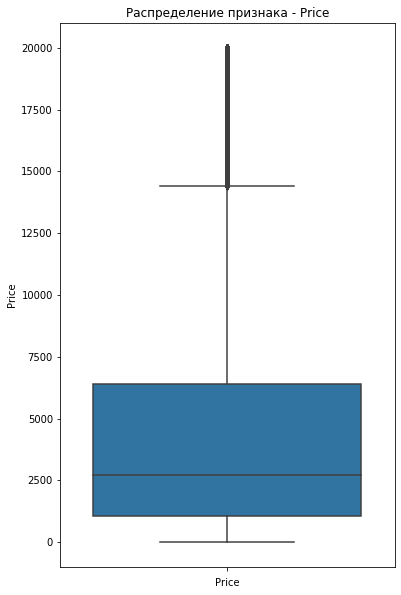

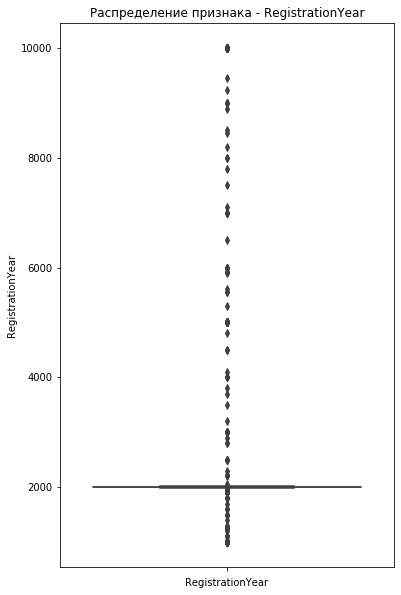

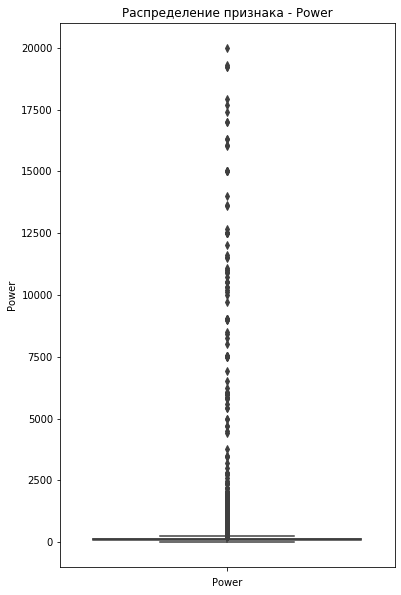

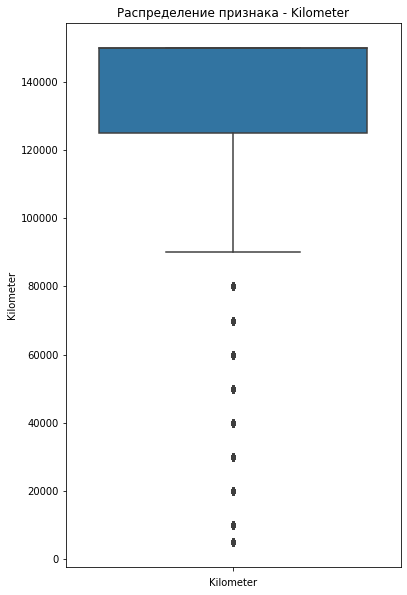

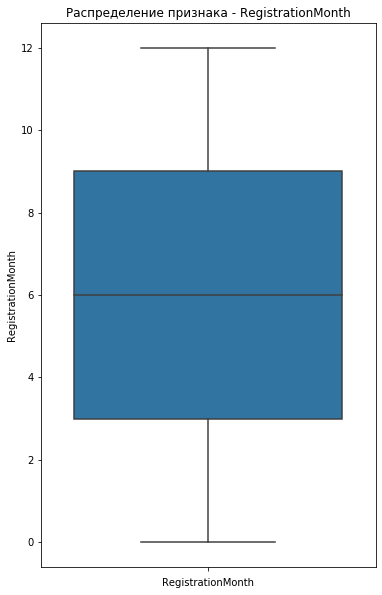

In [100]:
count_distribution(data_col_count)

Оценим количественные признаки:
- Цена - от 0 до 20000 - Ограничим данные для обучения с ценой больше 0, т.к предсказывать цену в 0 не разумно.
- Год регистрации - странные значения в далеком без автомобильном прошлом и далеко в будущем. (ограничим 1980 - 2021 гг.)
- Мощность двигателя - так же заставляет задуматься о значениях, по значениям некоторые продают самолет. (значения ограничим, ниже пояснение)
- Пробег - трогать не будем, вполне реалистичные значения (для России), в Европе +- возможно так же.
- Месяц регистрации - без изменений, 0 месяц говорит о том, что люди не знают точный месяц и ограничиваются годом.

Начнем с явных не реалистичных данных.

#### RegistrationYear

In [101]:
data['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Ограничим дата сет годами регистрации взяв бОльший диапазон, чем между 1 и 3 квартилями, 1980 и 2021 сильно в будущее заглядывать не будем, в прошлое относительно глубоко, без явного раритета.

In [102]:
print('До', len(data))
data = data[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2021)]
print('После', len(data))

До 354369
После 350812


После получили убыль в данных чуть менее 4 тыс объектов.

#### Power

По мощности всё сложнее, с одной стороны на просторах интернета найден автомобиль с 10-ю лошадиными силами (Daihatsu Midget), а максимальное количество достигало 1300 (Locus Plethore). 

Ограничим данные значениями мощности от 10 до 1300 л.с, для большей реалистичности. Неоторые владельцы могут не знать мощности на момент заполнения анкеты. Потери в объектах 442.

In [103]:
len(data[(data['Power'] < 10) & (data['Power'] > 0)])

212

In [104]:
len(data[data['Power'] > 1300])

230

In [105]:
data = data[(data['Power'] >= 10) & (data['Power'] <= 1300)]
data.shape[0]

311358

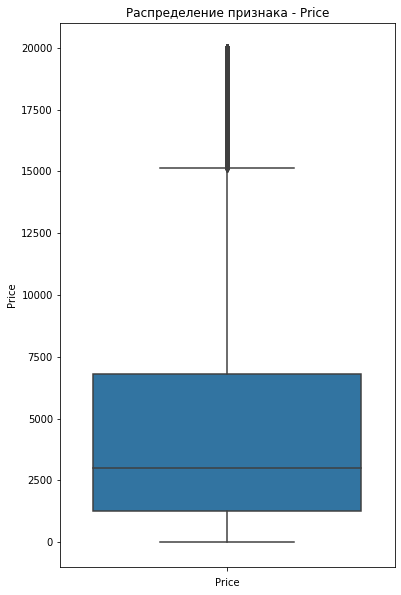

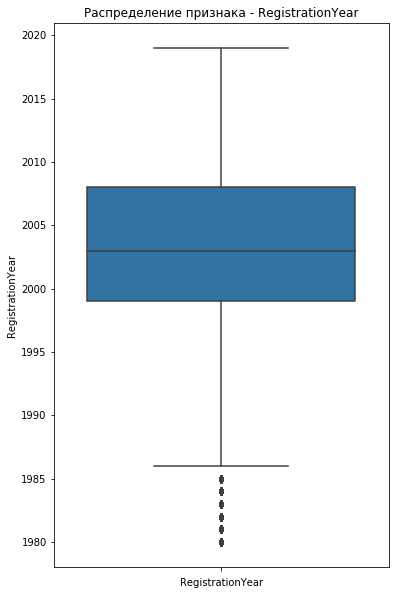

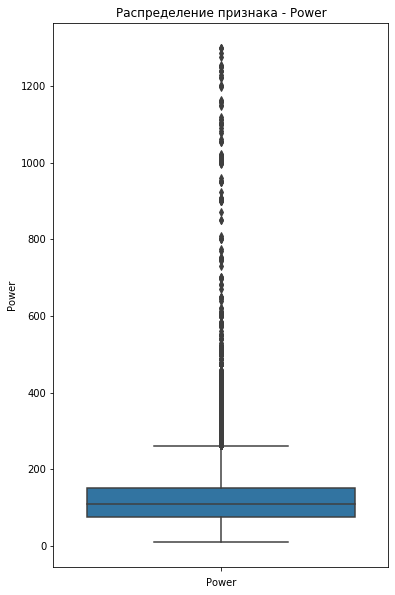

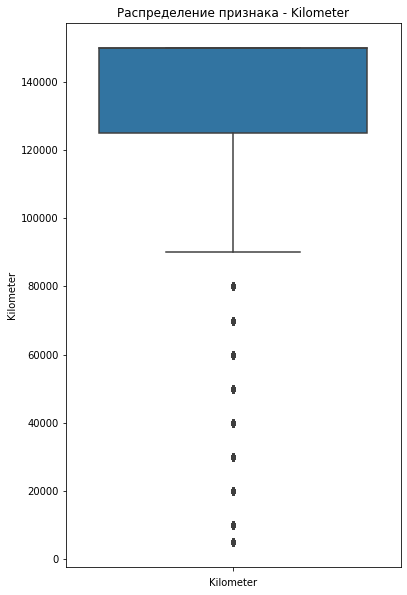

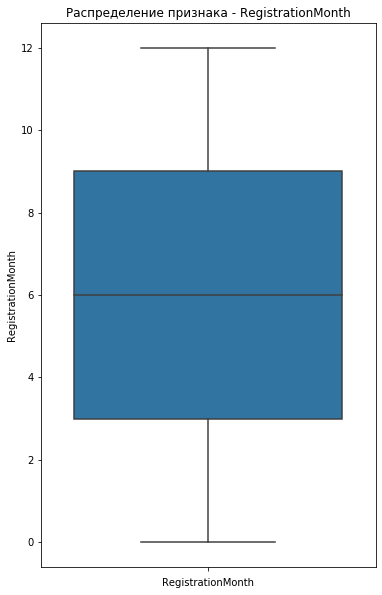

In [106]:
# рассмотрим обновленные данные распределения категориальных признаков 
count_distribution(data_col_count)

In [107]:
data[data_col_count].describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,311358.000000,311358.000000,311358.000000,311358.000000,311358.000000
mean,4682.749468,2003.487680,120.703223,128832.967195,5.941016
std,4576.008705,6.399332,56.349442,36489.267793,3.616634
min,0.000000,1980.000000,10.000000,5000.000000,0.000000
25%,1249.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2999.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6800.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,1300.000000,150000.000000,12.000000


Количественные признаки стали более реалистичные.

Основные предложения автомобилей с ценой от 3 до 4.5 тыс евро, годом выпуска 2003, мощностью 110 - 120 л.с, и пробегом свыше 100 000 км.

In [108]:
data.shape[0]

311358

#### Выводы по выбросам:

RegistrationYear - Ограничим дата сет годами регистрации взяв больший диапазон, чем между 1 и 3 квартилями, 1980 и 2021 сильно в будущее заглядывать не будем, в прошлое относительно глубоко, без явного раритета.

Power - Ограничим данные значениями мощности от 10 до 1300 л.с, для большей реалистичности. Неоторые владельцы могут не знать мощности на момент заполнения анкеты. Потери в объектах 442.

Признаки 'Kilometer', 'RegistrationMonth' оставим без изменений, 'Price' для обучения сделаем > 0. Километраж в 150 000 абсолютно реальное значение. Месяц регистрации 0 - значит не заполнено или не знают, знают только год.

После исключения выбросов количество объектов сократилось до 311358 с 354369

### Пропуски

In [109]:
data.isnull().mean()[data.isnull().mean() > 0]

VehicleType    0.072942
Gearbox        0.020484
Model          0.040927
FuelType       0.067405
NotRepaired    0.157732
dtype: float64

В процентном соотношении больше всего пропусков в бинарном признаке, был ремонт или нет.

In [110]:
for col in data.isnull().mean()[data.isnull().mean() > 0].index:
    print(data[col].value_counts(), '\n')
    print('Количество пропусков-', len(data[col][data[col].isnull()]), '\n\n')

sedan          83954
small          71152
wagon          60362
bus            26416
convertible    18678
coupe          14626
suv            10975
other           2484
Name: VehicleType, dtype: int64 

Количество пропусков- 22711 


manual    244184
auto       60796
Name: Gearbox, dtype: int64 

Количество пропусков- 6378 


golf                  26723
other                 20181
3er                   18196
polo                  11435
corsa                 10786
                      ...  
samara                    5
kalina                    5
rangerover                3
serie_2                   3
range_rover_evoque        2
Name: Model, Length: 248, dtype: int64 

Количество пропусков- 12743 


petrol      194159
gasoline     90464
lpg           4892
cng            502
hybrid         206
other           82
electric        66
Name: FuelType, dtype: int64 

Количество пропусков- 20987 


no     231241
yes     31006
Name: NotRepaired, dtype: int64 

Количество пропусков- 49111 




Краткая инструкция по заполнению:

 - VehicleType - всем пропущенным значениям присвоим категорию other
 - Model - всем пропущенным значениям присвоим категорию other
 - FuelType - всем пропущенным значениям присвоим категорию other
 - NotRepaired - если явно не указано нет, значит предположим что машина была в ремонте.
 - Gearbox - по наиболее частому значению в схожих параметрах.

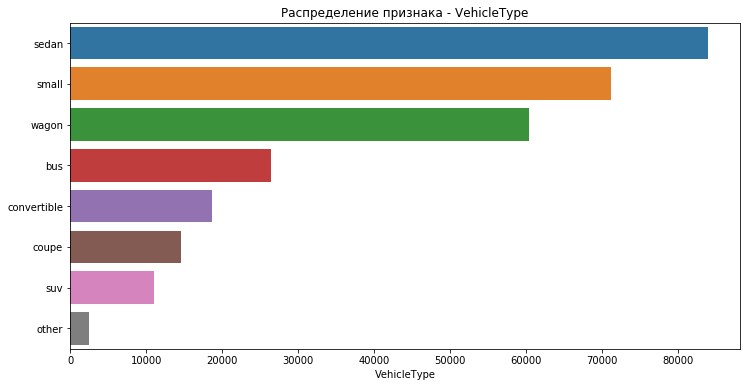

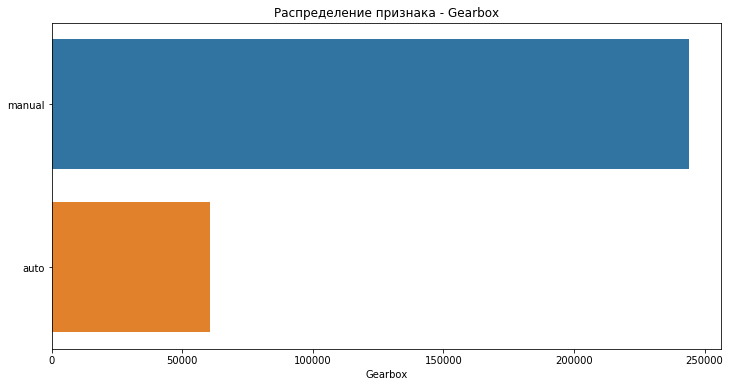

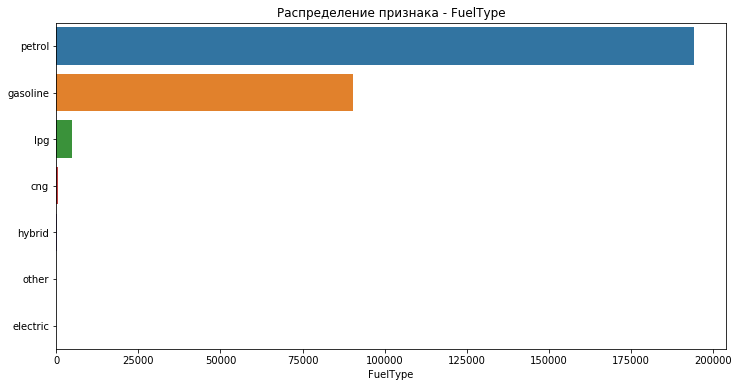

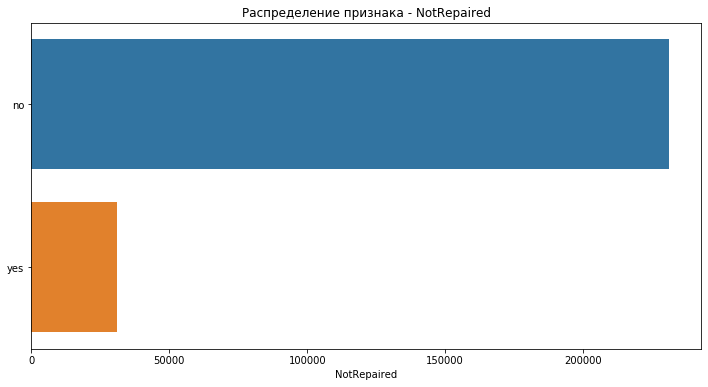

In [111]:
for col in [x for x in data.isnull().mean()[data.isnull().mean() > 0].index if x != 'Model']:
        plt.figure(figsize=(12,6))
        sns.barplot(
            y=data[col].value_counts().index, x=data[col].value_counts())
        plt.title(f'Распределение признака - {col}')
        plt.xlabel(col)
        plt.show()

In [112]:
data['NotRepaired'].fillna(value='yes', inplace=True) # заполнение пропусков в NotRepaired
data['VehicleType'].fillna(value='other', inplace=True) # заполнение пропусков в VehicleType
data['Model'].fillna(value='other', inplace=True) # заполнение пропусков в Model
data['FuelType'].fillna(value='other', inplace=True) # заполнение пропусков в FuelType
data['Gearbox'].isnull().sum() # количество пропусков в признаки тип трансмиссии

6378

Восстановление данных через группировку и нахождение типовой (часто встречающейся на рынке) трансмиссии

In [113]:
# находим схожие автомобили, по кузову, модели, марки, и году регистрации
for key, group in data.groupby(['VehicleType', 'Model', 'Brand', 'RegistrationYear']):
    # находим группы в которых элементов более 3 и есть пропуски
    if len(group) > 3 and group['Gearbox'].isnull().sum() > 0:
        # исключение на случай, если в серии group['Gearbox'] только NaN
        try:
            # most_cat какая часть самого часто встречающегося типа трансмиссии в выбранной группе
            most_cat = group['Gearbox'].value_counts()[0] / len(group['Gearbox'])
            # если процент выбранного типа трансмиссии более 80% то делаем замену нужного индекса
            # остальные оставляем без изменений ввиду возможности как одной, так и другой трансмиссии
            if most_cat > 0.8:
                for i in group['Gearbox'].isnull().loc[group['Gearbox'].isnull()].index:
                    data.loc[i,'Gearbox'] = group['Gearbox'].value_counts().index[0]
                        
        except IndexError:
            continue

In [114]:
data['Gearbox'].isnull().sum()

3137

Более половины пропусков удалось восстановить. Остальные 3137 объектов удаляем.

In [115]:
data.dropna(inplace=True)
data = data.reset_index()
data.shape[0]

308221

In [116]:
data_unzero_price = data[data['Price'] > 0].reset_index()
data_unzero_price.shape[0]

301661

### Вывод по выбросам и пропускам

После подготовки данных получили датасет из 301661 объектов, что на 15% меньше от исходного датасета. Данных достаточно для продолжения проекта.

### Подготовка к обучению

In [117]:
data.columns

Index(['index', 'DateCrawled', 'Price', 'VehicleType', 'RegistrationYear',
       'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth',
       'FuelType', 'Brand', 'NotRepaired', 'DateCreated', 'NumberOfPictures',
       'PostalCode', 'LastSeen'],
      dtype='object')

В признаки, для обучения внесем следующие данные: кузов, год регистрации, тип трансмиссии, пробег, мощность, модель, тип топлива, марка, был ли автомобиль в ремонте.

In [118]:
features = data_unzero_price[['VehicleType', 'RegistrationYear', 'Gearbox', 'Kilometer', 'Power',
       'Model', 'FuelType', 'Brand',
       'NotRepaired']]
target = data_unzero_price['Price']
features.head()

,VehicleType,RegistrationYear,Gearbox,Kilometer,Power,Model,FuelType,Brand,NotRepaired
0,coupe,2011,manual,125000,190,other,gasoline,audi,yes
1,suv,2004,auto,125000,163,grand,gasoline,jeep,yes
2,small,2001,manual,150000,75,golf,petrol,volkswagen,no
3,small,2008,manual,90000,69,fabia,gasoline,skoda,no
4,sedan,1995,manual,150000,102,3er,petrol,bmw,yes


Разделим на обучающую и валидационную выборку исходные признаки и целевой признак.

In [119]:
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.25, random_state=12345)

Для моделей, которые не могут работать с исходными данными, проведем кодирование.

Для кодирования используем OrdinalEncoder - т.к создаются порядковые номера, а не дополнительные признаки. В связи с этим кроме бустинга будем использовать решающее дерево и случайный лес. (Линейная не подходит из-за бинарной переменной о ремонте)

In [120]:
# порядковое кодирование категорийный признаков
encoder = OrdinalEncoder()
fit_features = features.drop(['Power', 'Kilometer'], axis=1)
encoder.fit(fit_features)
features_ordinal = pd.DataFrame(encoder.transform(fit_features), columns=fit_features.columns)

# добавляем количественные признаки
features_ordinal = features_ordinal.join(data_unzero_price[['Power', 'Kilometer']])

# сделаем нормировку по стандартному отклонению
for col in features_ordinal.columns:
    features_ordinal[col] = features_ordinal[col] / features_ordinal[col].std()

features_ordinal_train = pd.DataFrame(features_ordinal, index=features_train.index)
features_ordinal_valid = pd.DataFrame(features_ordinal, index=features_valid.index)

features_ordinal

,VehicleType,RegistrationYear,Gearbox,Model,FuelType,Brand,NotRepaired,Power,Kilometer
0,0.966693,4.889238,2.507322,2.370799,1.108650,0.074722,2.318603,3.386481,3.435284
1,2.900080,3.785217,0.000000,1.670985,1.108650,1.046112,2.318603,2.905244,3.435284
2,2.416734,3.312064,2.507322,1.656703,3.325951,2.839448,0.000000,1.336769,4.122341
3,2.416734,4.416086,2.507322,1.442474,1.108650,2.316392,0.000000,1.229827,2.473404
4,1.933387,2.365760,2.507322,0.157101,3.325951,0.149445,2.318603,1.818005,4.122341
...,...,...,...,...,...,...,...,...,...
301656,1.450040,5.677825,0.000000,0.057128,2.771625,0.000000,0.000000,2.673537,4.122341
301657,1.933387,3.785217,2.507322,1.999469,3.325951,2.241669,2.318603,4.010306,4.122341
301658,0.483347,3.154347,0.000000,1.513884,3.325951,2.391114,0.000000,1.800182,3.435284
301659,0.000000,2.523478,2.507322,3.170586,1.108650,2.839448,0.000000,1.818005,4.122341


## Обучение и анализ результатов моделей

### Дерево

In [121]:
pivot_result = pd.DataFrame(index=['DecisionTreeRegressor',
                                   'RandomForestRegressor', 
                                   'LGBMRegressor', 
                                   'CatBoostRegressor'],
                            columns=['best_scores', 'time_spend'])

In [122]:
MSE = make_scorer(mean_squared_error)
best_scores = time_spend = 999999


for depth in range(1,20,2):
    sec_begin_train = time.time()
    
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores = cross_val_score(model, features_ordinal, target, scoring=MSE, cv=5)
    
    sec_end_train = time.time()
    print('depth =', depth, 'scores =',scores.mean() ** 0.5, 'full time =', sec_end_train - sec_begin_train)
    
    if best_scores > scores.mean() ** 0.5:
        best_scores = scores.mean() ** 0.5
        time_spend = sec_end_train - sec_begin_train
        
pivot_result.loc['DecisionTreeRegressor'] = {'best_scores':round(best_scores,2), 'time_spend':round(time_spend,2)}

depth = 1 scores = 3723.449228510683 full time = 0.32883358001708984
depth = 3 scores = 2939.001199175142 full time = 0.7464344501495361
depth = 5 scores = 2429.008443358361 full time = 1.158226728439331
depth = 7 scores = 2164.668228268482 full time = 1.4998445510864258
depth = 9 scores = 2012.2996678047202 full time = 1.859138011932373
depth = 11 scores = 1901.402724971044 full time = 2.1642556190490723
depth = 13 scores = 1841.2421150997732 full time = 2.5029468536376953
depth = 15 scores = 1832.6255827432137 full time = 2.740718126296997
depth = 17 scores = 1856.1685496193443 full time = 3.092435598373413
depth = 19 scores = 1881.0428891604283 full time = 3.29939341545105


Модель обучается и предсказывает очень быстро, но метрика выше чем у моделей ниже.

### Случайные лес

In [123]:
for esti in range(5, 20, 1):
    sec_begin_train = time.time()
    
    model = RandomForestRegressor(n_estimators=esti, random_state=12345, n_jobs=-1)
    scores = cross_val_score(model, features_ordinal, target, scoring=MSE, cv=5)
    
    sec_end_train = time.time()
    
    print('esti =', esti,
          'scores =', scores.mean() ** 0.5,
          'full time =', sec_end_train - sec_begin_train)
    
    if best_scores > scores.mean() ** 0.5:
        best_scores = scores.mean() ** 0.5
        time_spend = sec_end_train - sec_begin_train
    
pivot_result.loc['RandomForestRegressor'] = {'best_scores':round(best_scores,2), 'time_spend':round(time_spend,2)}

esti = 5 scores = 1682.7717906393193 full time = 12.93770456314087
esti = 6 scores = 1666.5218967101853 full time = 15.790127515792847
esti = 7 scores = 1654.9733129289284 full time = 17.816105604171753
esti = 8 scores = 1645.4463224715 full time = 20.639607667922974
esti = 9 scores = 1637.8625786069506 full time = 23.40847873687744
esti = 10 scores = 1632.0543519530731 full time = 25.61377787590027
esti = 11 scores = 1628.9505669079485 full time = 28.203670024871826
esti = 12 scores = 1624.8774397149457 full time = 30.50451970100403
esti = 13 scores = 1622.3821562584078 full time = 33.39492106437683
esti = 14 scores = 1620.2247244363962 full time = 35.19064402580261
esti = 15 scores = 1617.2525167923768 full time = 37.85170793533325
esti = 16 scores = 1615.7860186590888 full time = 40.601826429367065
esti = 17 scores = 1614.8062118517455 full time = 42.97838354110718
esti = 18 scores = 1613.6299957302765 full time = 45.56282091140747
esti = 19 scores = 1612.3787431146263 full time = 4

Хорошие показатели по времени обучения и предсказания, метрика лучше чем у решающего дерева.

Увеличение количества деревьев и ветвей ведет к не значительному уменьшению значения метрики RMSE (в пределах 100 евро), но длительность обучения при этом сильно увеличивается.

### Light Gradient Boosted Machine

In [126]:
features_LGBM = features

for col in ['VehicleType', 'Gearbox',
       'Model', 'FuelType', 'Brand',
       'NotRepaired']:
    features_LGBM[col] = features_LGBM[col].astype('category')

    
features_LGBM_train, features_LGBM_valid, target_LGBM_train, target_LGBM_valid = \
train_test_split(features_LGBM, target, test_size=0.25, random_state=12345)

In [127]:
model = LGBMRegressor(random_state=12345, n_estimators=100, learning_rate=0.5)

In [128]:
sec_begin_train = time.time()
model.fit(features_LGBM_train, target_LGBM_train)
sec_end_train = time.time()

print('time_fit =', sec_end_train - sec_begin_train)

time_fit = 4.466915845870972


In [129]:
sec_begin_predict= time.time()
pred_valid = model.predict(features_LGBM_valid)
sec_end_predict = time.time()

print('RMSE =', mean_squared_error(target_LGBM_valid, pred_valid) ** 0.5, 'time_predict =', sec_end_predict - sec_begin_predict)

RMSE = 1598.3067560380384 time_predict = 0.49738192558288574


In [130]:
pivot_result.loc['LGBMRegressor'] = {'best_scores':round(mean_squared_error(target_LGBM_valid, pred_valid) ** 0.5,2),
                                     'time_spend':round((sec_end_predict - sec_begin_predict) + (sec_end_train - sec_begin_train),2)}

Данная модель показывает хорошие результаты, как по значению метрики RMSE, так и по времени обучения и предсказания.

### CatBoost

In [131]:
model = CatBoostRegressor(loss_function='RMSE', random_state=12345, iterations=50, learning_rate=0.8)

In [132]:
cat_features = ['VehicleType', 'Gearbox',
       'Model', 'FuelType', 'Brand',
       'NotRepaired']

In [133]:
sec_begin_train = time.time()
model.fit(features_train, target_train, cat_features = cat_features, verbose=50)
sec_end_train = time.time()

print('time_fit =', sec_end_train - sec_begin_train)

0:	learn: 2696.1303726	total: 183ms	remaining: 8.97s
49:	learn: 1678.1879232	total: 9.16s	remaining: 0us
time_fit = 10.591465711593628


In [134]:
sec_begin_predict= time.time()
pred_valid = model.predict(features_valid)
sec_end_predict = time.time()

print('RMSE =', mean_squared_error(target_valid, pred_valid) ** 0.5, 'time_predict =', sec_end_predict - sec_begin_predict)

RMSE = 1707.771840245835 time_predict = 0.10936665534973145


In [135]:
pivot_result.loc['CatBoostRegressor'] = {'best_scores':round(mean_squared_error(target_valid, pred_valid) ** 0.5,2),
                                         'time_spend':round((sec_end_predict - sec_begin_predict) + (sec_end_train - sec_begin_train),2)}

У данной модели показатели хуже как по необходимой метрике, так и по затраченному времени. 

При изменении гиперпараметров в сторону уменьшения скорости обучения или увеличения количества итераций, время сильно возрастает. 

От количества итераций метрика умеьшаеся в значении. При умеьшении скорости значение метрики наоборот растет.

## Общий вывод и рекомендации по моделям

In [136]:
pivot_result

,best_scores,time_spend
DecisionTreeRegressor,1832.63,2.74
RandomForestRegressor,1612.38,48.03
LGBMRegressor,1598.31,4.96
CatBoostRegressor,1707.77,10.7


Для заказчика:
 - модель будет лучше работать если внести в анкетирование дополнительные параметры (тип сделки: продажа, обмен, другие варианты)
 - на текущих данных по качеству, скорости предсказания и времени обучения, рекомендовано использовать LGBM.
 
 Случайный лес так же показал хорошие результаты, но при изменении гиперпараметров время обучения сильно пострадает, поэтому при масштабируемости исходной задачи рекомендовано остановиться на LGBM.